Импорт необходимых библиотек:

In [151]:
import pandas as pd
import numpy as np
import wfdb
import ast
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, filtfilt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.metrics import confusion_matrix 

Чтение файла с описанием ЭКГ:

In [152]:
path = str(Path("C:/Users/DARYA/Desktop/Study_project/").resolve()) + r'/'

sampling_rate=100

# load and convert annotation data
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

In [153]:
def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

In [154]:
Y.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr,[NORM]
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr,[NORM]
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr,[NORM]
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr,[NORM]
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr,[NORM]


Отфильтруем адатсет по следующим признакам:
 - ЭКГ должно быть проверено человеком (validated_by_human)
 - Должны быть провекра ЖКГ (validated_by)
 - В данных с отведений не должно быть шумов и других проблем (baseline_drift, static_noise, burst_noise, electrodes_problems)

In [155]:
Y = Y[Y['validated_by_human']]
Y = Y[Y['baseline_drift'].isnull()]
Y = Y[Y['static_noise'].isnull()]
Y = Y[Y['burst_noise'].isnull()]
Y = Y[Y['electrodes_problems'].isnull()]
Y = Y[Y['validated_by'] > 0]

Отнормируем диагнозы - если в классе диагноза есть 'NORM', то это нормальное (без диагноза) ЭКГ

In [156]:
Y['diag_class'] = Y['diagnostic_superclass'].apply(lambda x: 'NORM' if 'NORM' in x else 'NOT NORM')

In [157]:
Y.head()

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,diagnostic_superclass,diag_class
ecg_id,,,,,,,,,,,,,,,,,,,,,
23,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-01-25 12:49:40,"2:1 Überleitung bei vorhofflattern,jetzt unter...",...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00023_lr,records500/00000/00023_hr,[],NOT NORM
28,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-01 12:58:55,sinusrhythmus verdacht auf p-sinistrocardiale ...,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00028_lr,records500/00000/00028_hr,[STTC],NOT NORM
39,13619.0,56.0,0,NaN,NaN,2.0,0.0,CS-12 E,1985-02-16 12:54:01,sinusrhythmus linkstyp qrs(t) abnormal infe...,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00039_lr,records500/00000/00039_hr,"[STTC, MI]",NOT NORM
71,15551.0,49.0,0,NaN,94.0,0.0,0.0,CS-12 E,1985-08-01 09:58:57,sinusrhythmus normales ekg ergo: 225 watt ob...,...,NaN,NaN,NaN,NaN,NaN,8,records100/00000/00071_lr,records500/00000/00071_hr,[NORM],NORM
134,10784.0,68.0,0,NaN,NaN,NaN,3.0,AT-6 C,1986-02-21 11:22:18,sinusrytm vÄnster el-axel inget sÄkert patolog...,...,NaN,NaN,NaN,NaN,NaN,9,records100/00000/00134_lr,records500/00000/00134_hr,[STTC],NOT NORM


C:\Users\DARYA\AppData\Local\Temp\ipykernel_11332\83737117.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )


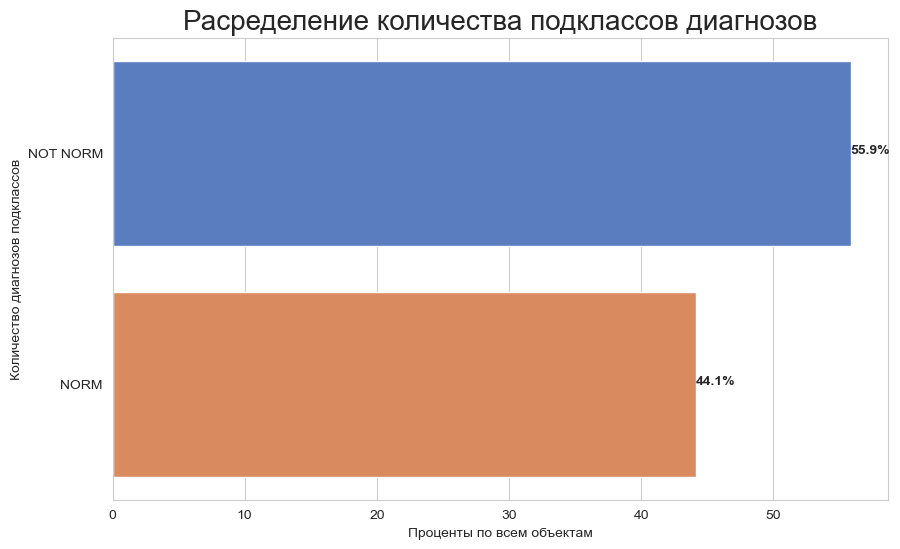

In [158]:

vc = Y['diag_class'].value_counts()

sns.set_style("whitegrid")
bar,ax = plt.subplots(figsize=(10,6))
ax = sns.barplot(x=vc.values/vc.values.sum()*100., y=vc.index, ci=None, palette="muted",orient='h' )
ax.set_title("Расределение количества подклассов диагнозов", fontsize=20)
ax.set_xlabel ("Проценты по всем объектам")
ax.set_ylabel ("Количество диагнозов подклассов")
for rect in ax.patches:
    ax.text (rect.get_width(), rect.get_y() + rect.get_height() / 2,"%.1f%%"% rect.get_width(), weight='bold' )
plt.show()   

Прочитаем оставшиеся ЭКГ:

In [159]:
def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

In [160]:
path = str(Path("C:/Users/DARYA/Desktop/Study_project/").resolve()) + r'/'

sampling_rate=100

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)



Данные за промежуток времени получают с прибора, записывают этот массив с другими данными. После того как записали, у нас получается двумерный массив, но ЭКГ у нас не одно - поэтому все ЭКГ тоже записываются в массив. И получается трёхмерный массив.

Отделим данные с каждого отведения в отдельный датасет:

In [161]:
da1=[]
da2=[]
da3=[]
da4=[]
da5=[]
da6=[]
da7=[]
da8=[]
da9=[]
da10=[]
da11=[]
da12=[]
for i in range(len(X)):
    a1=[]
    a2=[]
    a3=[]
    a4=[]
    a5=[]
    a6=[]
    a7=[]
    a8=[]
    a9=[]
    a10=[]
    a11=[]
    a12=[]
    for j in range(len(X[i])):
        a1.append(X[i][j][0])
        a2.append(X[i][j][1])
        a3.append(X[i][j][2])
        a4.append(X[i][j][3])
        a5.append(X[i][j][4])
        a6.append(X[i][j][5])
        a7.append(X[i][j][6])
        a8.append(X[i][j][7])
        a9.append(X[i][j][8])
        a10.append(X[i][j][9])
        a11.append(X[i][j][10])
        a12.append(X[i][j][11])
    da1.append(a1)
    da2.append(a2)
    da3.append(a3)
    da4.append(a4)
    da5.append(a5)
    da6.append(a6)
    da7.append(a7)
    da8.append(a8)
    da9.append(a9)
    da10.append(a10)
    da11.append(a11)
    da12.append(a12)

In [162]:
ind = Y.index
df1_1 = pd.DataFrame(da1, index = Y.index)
df1_2 = pd.DataFrame(da2, index = ind)
df1_3 = pd.DataFrame(da3, index = ind)
df1_4 = pd.DataFrame(da4, index = ind)
df1_5 = pd.DataFrame(da5, index = ind)
df1_6 = pd.DataFrame(da6, index = ind)
df1_7 = pd.DataFrame(da7, index = ind)
df1_8 = pd.DataFrame(da8, index = ind)
df1_9 = pd.DataFrame(da9, index = ind)
df1_10 = pd.DataFrame(da10, index = ind)
df1_11 = pd.DataFrame(da11, index = ind)
df1_12 = pd.DataFrame(da12, index = ind)

In [163]:
df = [df1_1, df1_2, df1_3, df1_4, df1_5, df1_5, df1_7, df1_8, df1_9, df1_10, df1_11, df1_12]


In [164]:
df[0]

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
ecg_id,,,,,,,,,,,,,,,,,,,,,
23,-0.244,-0.211,-0.117,-0.077,-0.063,-0.020,-0.068,-0.071,-0.041,-0.055,...,-0.127,-0.124,-0.131,-0.120,-0.098,-0.109,-0.083,-0.077,-0.111,-0.113
28,0.026,0.016,-0.058,-0.023,0.007,0.027,0.031,0.015,0.022,0.050,...,-0.039,-0.111,-0.035,-0.089,0.006,-0.121,0.089,-0.130,0.057,0.728
39,-0.155,-0.164,-0.167,-0.135,-0.133,-0.150,-0.143,-0.135,-0.130,-0.121,...,-0.096,-0.096,-0.102,-0.113,-0.095,-0.095,-0.112,-0.102,-0.114,-0.133
71,-0.015,-0.014,-0.010,-0.007,-0.002,0.001,-0.003,-0.011,-0.011,-0.007,...,-0.035,-0.011,0.007,0.016,0.031,0.025,0.046,0.082,0.089,0.097
134,0.073,0.065,0.045,-0.010,-0.043,-0.040,-0.053,-0.069,-0.045,-0.055,...,0.020,0.546,0.855,0.184,-0.193,-0.210,-0.385,-0.512,-0.298,0.058
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21830,-0.085,-0.084,-0.029,-0.058,-0.100,-0.067,-0.051,-0.053,-0.051,-0.042,...,0.026,0.005,-0.001,-0.009,-0.055,-0.047,-0.033,0.000,-0.018,0.011
21831,-0.056,-0.058,-0.055,-0.055,-0.052,-0.049,-0.049,-0.044,-0.060,-0.077,...,-0.076,-0.080,-0.080,-0.068,-0.072,-0.059,-0.061,-0.057,-0.068,-0.065
21832,-0.076,-0.066,-0.049,-0.041,-0.032,-0.051,-0.047,-0.031,-0.039,-0.050,...,-0.002,-0.026,-0.014,-0.008,-0.033,-0.072,-0.124,-0.132,-0.081,-0.047


In [ ]:
#for i in df:
#    i['diag'] = Y['diag_class']

In [165]:
y = Y['diag_class']


In [ ]:
#df1 = []
#for i in df:
 #   df1.append(i.drop(columns=['diag']))

Во время ЭКГ могут быть единичные выбросы. Избавимся от них с помощью butter (фильтр Баттерворта) и filtfilt (удаление искажений)

In [166]:
def butter_lowpass_filter(data, cutoff_freq, fs, order=5):
        nyquist_freq = 0.5 * fs
        normal_cutoff = cutoff_freq / nyquist_freq
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        filtered_data = filtfilt(b, a, data)
        return filtered_data

filt_ecg = []
for i in df:
    ecg_signal = i
    sampling_rate = 125
    cutoff_frequency = 50  
    filtered_ecg_signal = butter_lowpass_filter(ecg_signal, cutoff_frequency, sampling_rate)
    filt_ecg.append(filtered_ecg_signal)

Обучим модели с помощью дерева решений для каждого отведения:

In [167]:
models = []
test = []

for i in filt_ecg:
    X_val, X_test_new, y_val, y_test_new = train_test_split(i, y, test_size=0.7, random_state=42)
    test.append([X_test_new, y_test_new])
    clf_dt = DecisionTreeClassifier(random_state=42)
    clf_dt.fit(X_val, y_val)
    models.append(clf_dt)

In [168]:
y_pred=[]
for i in range(len(models)):
    y_pred.append(models[i].predict(test[i][0]))

In [169]:
from sklearn.metrics import accuracy_score
for i in range(len(y_pred)):
    print(round(accuracy_score(test[i][1], y_pred[i]),3))

0.538
0.545
0.549
0.55
0.553
0.553
0.547
0.528
0.553
0.551
0.561
0.557


Для классификации, использующей Ридж регрессию переведем классы в целочисленный тип и обучим модели:

In [170]:
y1 = y.apply(lambda x: 1 if x == 'NORM' else 0)

In [172]:
from sklearn import linear_model
models1 = []
test1 = []

for i in filt_ecg:
    X_val, X_test_new, y_val, y_test_new = train_test_split(i, y1, test_size=0.7, random_state=42)
    test1.append([X_test_new, y_test_new])
    clf_dt = linear_model.RidgeClassifier()
    clf_dt.fit(X_val, y_val)
    models1.append(clf_dt)

In [ ]:
y_pred1 = []
for i in range(len(models1)):
    x = models1[i].predict(test1[i][0])
    y_pred1.append(x)

In [181]:
from sklearn.metrics import confusion_matrix 
for i in range(len(y_pred1)):
    dc_mf_tn, dc_mf_fp, dc_mf_fn, dc_mf_tp = confusion_matrix(test1[i][1], y_pred1[i], labels = [0, 1]).ravel()
    sum_dc = dc_mf_tn + dc_mf_fp + dc_mf_fn + dc_mf_tp
    print(f'{i+1} отведение:')
    print(f'Правильно определили нормальное ЭКГ - {dc_mf_tn} ШТ ({round(dc_mf_tn/sum_dc,3)})')
    print(f'Правильно определили не нормальное ЭКГ - {dc_mf_tp} ШТ ({round(dc_mf_tp/sum_dc,3)})')
    print(f'Не правильно определили нормальное ЭКГ - {dc_mf_fn} ШТ ({round(dc_mf_fn/sum_dc,3)})')
    print(f'Не правильно определили не нормальное ЭКГ - {dc_mf_fp} ШТ ({round(dc_mf_fp/sum_dc,3)})')
    print(f'Правильно определили тип для {round((dc_mf_tn + dc_mf_tp) /sum_dc*100,2)}%\n')
    
    

1 отведение:
Правильно определили нормальное ЭКГ - 1062 ШТ (0.305)
Правильно определили не нормальное ЭКГ - 675 ШТ (0.194)
Не правильно определили нормальное ЭКГ - 886 ШТ (0.254)
Не правильно определили не нормальное ЭКГ - 859 ШТ (0.247)
Правильно определили тип для 49.89%

2 отведение:
Правильно определили нормальное ЭКГ - 1119 ШТ (0.321)
Правильно определили не нормальное ЭКГ - 652 ШТ (0.187)
Не правильно определили нормальное ЭКГ - 909 ШТ (0.261)
Не правильно определили не нормальное ЭКГ - 802 ШТ (0.23)
Правильно определили тип для 50.86%

3 отведение:
Правильно определили нормальное ЭКГ - 993 ШТ (0.285)
Правильно определили не нормальное ЭКГ - 814 ШТ (0.234)
Не правильно определили нормальное ЭКГ - 747 ШТ (0.215)
Не правильно определили не нормальное ЭКГ - 928 ШТ (0.267)
Правильно определили тип для 51.9%

4 отведение:
Правильно определили нормальное ЭКГ - 1151 ШТ (0.331)
Правильно определили не нормальное ЭКГ - 624 ШТ (0.179)
Не правильно определили нормальное ЭКГ - 937 ШТ (0.269)